<a href="https://colab.research.google.com/github/O-Kpy/Kaggle/blob/main/tabular_playground_series_2021_aug_tabular_playground_series_aug_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone --recursive https://github.com/Microsoft/LightGBM

Cloning into 'LightGBM'...
remote: Enumerating objects: 23345, done.
remote: Counting objects: 100% (1022/1022), done.
remote: Compressing objects: 100% (571/571), done.
remote: Total 23345 (delta 633), reused 734 (delta 431), pack-reused 22323
Receiving objects: 100% (23345/23345), 18.13 MiB | 24.21 MiB/s, done.
Resolving deltas: 100% (17026/17026), done.
Submodule 'include/boost/compute' (https://github.com/boostorg/compute) registered for path 'external_libs/compute'
Submodule 'eigen' (https://gitlab.com/libeigen/eigen.git) registered for path 'external_libs/eigen'
Submodule 'external_libs/fast_double_parser' (https://github.com/lemire/fast_double_parser.git) registered for path 'external_libs/fast_double_parser'
Submodule 'external_libs/fmt' (https://github.com/fmtlib/fmt.git) registered for path 'external_libs/fmt'
Cloning into '/content/LightGBM/external_libs/compute'...
remote: Enumerating objects: 21731, done.        
remote: Counting objects: 100% (3/3), done.        
remote: 

In [ ]:
%cd /content/LightGBM

/content/LightGBM


In [ ]:

!mkdir build
!cmake -DUSE_GPU=1
!make -j$(nproc)
!sudo apt-get -y install python-pip
!sudo -H pip install setuptools pandas numpy scipy scikit-learn -U
%cd /content/LightGBM/python-package/
!sudo python setup.py install --precompile

-- The C compiler identification is GNU 7.5.0
-- The CXX compiler identification is GNU 7.5.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc -- works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ -- works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Found OpenMP_C: -fopenmp (found version "4.5") 
-- Found OpenMP_CXX: -fopenmp (found version "4.5") 
-- Found OpenMP: TRUE (found version "4.5")  
-- Looking for CL_VERSION_2_2
-- Looking for CL_VERSION_2_2 - found
-- Found OpenCL: /usr/lib/x86_64-linux-gnu/libOpenCL.so (found version "2.2") 
-- OpenCL include directory: /usr/include
-- Boost version: 1.65.1
-- Found the following Boost libraries:
--

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import scipy
from scipy.stats import skew
import warnings
warnings.filterwarnings('ignore')

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/dataset/kaggle/tabular-playground-series/2021-aug/tabular-playground-series-aug-2021_train.csv')
test = pd.read_csv('/content/drive/MyDrive/dataset/kaggle/tabular-playground-series/2021-aug/tabular-playground-series-aug-2021_test.csv')
submit = pd.read_csv('/content/drive/MyDrive/dataset/kaggle/tabular-playground-series/2021-aug/tabular-playground-series-aug-2021_sample_submission.csv')
train.shape, test.shape, submit.shape

((250000, 102), (150000, 101), (150000, 2))

In [ ]:
train['loss'].skew()  # target 라벨에 log1p씌울까 

1.4653191365369271

Text(0.5, 1.0, 'Train set Skew')

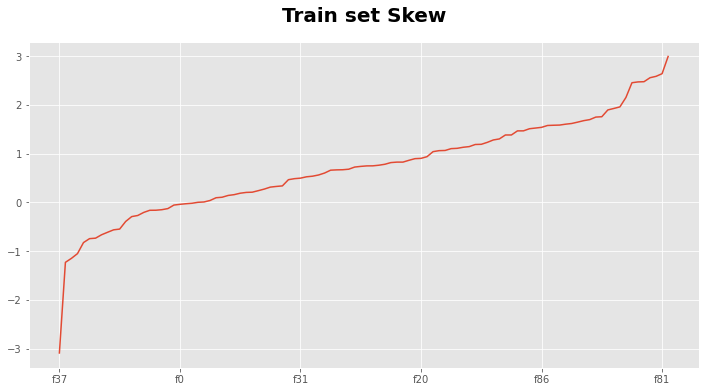

In [ ]:
plt.figure(figsize=(12,6))
train.skew().sort_values().plot()
plt.title('Train set Skew', fontsize=20, fontweight='bold', pad=20)
# noramlize를 적용 할까 고민

# cluster DBSCAN기법

- DBSCAN(density-based spatial clustering of application with noise)은 클러스터의 갯수를 미리 지정하지 않는 군집 알고리즘


- DBSCAN은 병합 군집이나 k-평균보다는 다소 느리지만 비교적 큰 데이터셋에도 적용



- 데이터의 밀집지역이 한 클러스터를 구성하며 비교적 비어있는 지역을 경계로 다른 클러스터와 구분함



- DBSCAN은 특성 공간에서 가까이 있는 데이터가 많아 붐비는 지역의 포인트를 찾음

- 이런 지역을 밀집 지역dense region이라 함

- 밀집 지역에 있는 포인트를 핵심 포인트core point라고함



- 핵심 포인트: min_samples, epsepsilon

  - 한 데이터 포인트에서 eps 거리 안에 데이터가 min_samples 갯수만큼 들어 있으면 이 데이터 포인트를 핵심 포인트로 분류

  - eps(거리)보다 가까운 핵심 샘플은 동일한 클러스터로 분류

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

data = pd.concat([train.drop(columns=['id']), test.drop(columns=['id'])], axis=0)
data_columns = data.columns

for i in data.columns:
  if i == 'loss':
    continue
  data[i] = MinMaxScaler().fit_transform(data[[i]])

In [ ]:
from sklearn.cluster import DBSCAN

data['cluster'] = DBSCAN(n_jobs=-1).fit_predict(data.drop(columns=['loss']))
data

KeyboardInterrupt: ignored

# Clustering 적용하자

In [ ]:
!pip install catboost
!pip install optuna

     |████████████████████████████████| 67.4 MB 51 kB/s 
     |████████████████████████████████| 302 kB 9.5 MB/s 
     |████████████████████████████████| 80 kB 12.8 MB/s 
     |████████████████████████████████| 208 kB 61.3 MB/s 
     |████████████████████████████████| 75 kB 6.5 MB/s 
     |████████████████████████████████| 141 kB 74.8 MB/s 
     |████████████████████████████████| 111 kB 77.8 MB/s 
     |████████████████████████████████| 49 kB 8.7 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=22377c4f67d741e6e131f1edbedcd7164649d8c1077c31df5cfdae638f9b5c0c
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [ ]:
import catboost
import optuna
import optuna.integration.lightgbm as lgbo
import lightgbm
import xgboost
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, StratifiedKFold, LeaveOneGroupOut, train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [ ]:
# 데이터 나누기
x_train = train.drop(columns=['id', 'loss'])
y_train = train['loss']
x_test = test.drop(columns=['id'])
x_train_columns = x_train.columns
x_test_columns = x_test.columns
x_train.shape, y_train.shape, x_test.shape

((250000, 100), (250000,), (150000, 100))

In [ ]:
mm = MinMaxScaler().fit(x_train)
x_train = mm.transform(x_train)
x_test = mm.transform(x_test)

x_train = pd.DataFrame(x_train, columns=x_train_columns)
x_test = pd.DataFrame(x_test, columns=x_test_columns)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



Text(0.5, 1.0, 'elbow method')

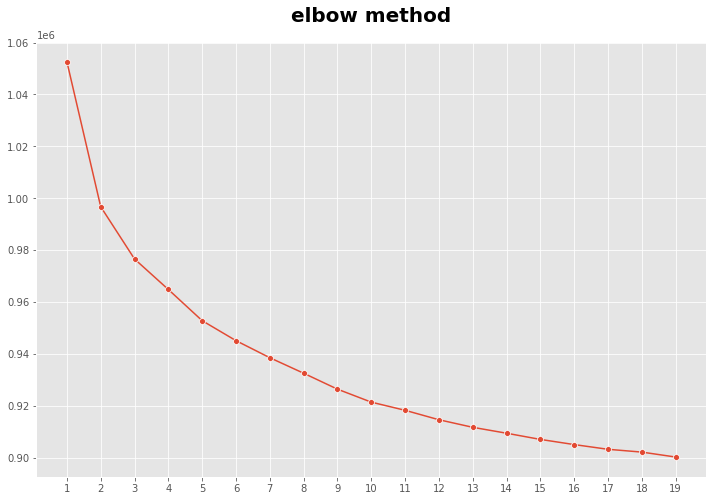

In [ ]:
# Clustering
from sklearn.cluster import KMeans

vstack = np.vstack((x_train,
                    x_test))

sse = {}
for i in range(1,20, 1):
  km = KMeans(n_clusters=i, max_iter=1000, random_state=0, n_jobs=-1).fit(vstack)
  sse[i] = km.inertia_

plt.figure(figsize=(12,8))
sns.lineplot(pd.Series(sse).index, pd.Series(sse), marker='o')
plt.xticks(pd.Series(sse).index)
plt.title('elbow method', fontsize=20, fontweight='bold', pad=20)

In [ ]:
km = KMeans(n_splits=, max_iter=1000, n_jobs=-1).fit(vstack)

x_train['cluster'] = km.predict(x_train)
x_test['cluster'] = km.predict(x_test)

In [ ]:
sk = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
preds = np.zeros((x_test.shape[0],))

for i, (train_index, valid_index) in enumerate(kf.split(x_train, y_train)):
  X_train, X_valid = x_train.iloc[train_index], x_train.iloc[valid_index]
  Y_train, Y_valid = y_train.iloc[train_index], y_train.iloc[valid_index]

  model_cat = catboost.CatBoostRegressor(iterations=3000, learning_rate=0.022, loss_function='RMSE', eval_metric='RMSE', task_type='GPU')
  model_cat.fit(X_train, Y_train, eval_set=(X_valid, Y_valid), verbose=100, early_stopping_rounds=70)

  preds += np.expm1(model_cat.predict(x_test)) / kf.n_splits

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

0:	learn: 1.1039045	test: 1.1063753	best: 1.1063753 (0)	total: 10.3ms	remaining: 30.9s
100:	learn: 1.0945647	test: 1.0977858	best: 1.0977858 (100)	total: 1.8s	remaining: 51.6s
200:	learn: 1.0901819	test: 1.0942911	best: 1.0942911 (200)	total: 2.91s	remaining: 40.6s
300:	learn: 1.0869794	test: 1.0920953	best: 1.0920953 (300)	total: 4.21s	remaining: 37.7s
400:	learn: 1.0843921	test: 1.0905177	best: 1.0905177 (400)	total: 5.58s	remaining: 36.2s
500:	learn: 1.0821666	test: 1.0893155	best: 1.0893155 (500)	total: 7.41s	remaining: 37s
600:	learn: 1.0800835	test: 1.0882926	best: 1.0882926 (600)	total: 9.82s	remaining: 39.2s
700:	learn: 1.0781490	test: 1.0874149	best: 1.0874149 (700)	total: 12.1s	remaining: 39.7s
800:	learn: 1.0763697	test: 1.0866818	best: 1.0866818 (800)	total: 14.4s	remaining: 39.6s
900:	learn: 1.0746677	test: 1.0860741	best: 1.0860741 (900)	total: 16.9s	remaining: 39.3s
1000:	learn: 1.0730308	test: 1.0855342	best: 1.0855342 (1000)	total: 18.9s	remaining: 37.8s
1100:	learn: 1

# LGBM LB: 7.90478

In [ ]:
params = {'objective':'poisson', 'metric': 'rmse', 'device':'gpu'} #'objective': 'mean_squared_error',
from sklearn.metrics import mean_absolute_error
X_train, X_test, Y_train, Y_test = train_test_split(x_train, y_train, test_size=0.3, random_state=42)
lgb_train = lightgbm.Dataset(X_train, Y_train)
lgb_valid = lightgbm.Dataset(X_test, Y_test)
model = lgbo.train(params, lgb_train, valid_sets=[lgb_valid], verbose_eval=False, num_boost_round=100, early_stopping_rounds=5) 
model.params

[I 2021-08-31 04:36:10,577] A new study created in memory with name: no-name-ad89208e-5b23-4827-b026-9edec02d906b
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 175000, number of used features: 100
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 100 dense feature groups (16.69 MB) transferred to GPU in 0.019901 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 1.920970


feature_fraction, val_score: 7.879588:  14%|#4        | 1/7 [00:11<01:07, 11.19s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 175000, number of used features: 100
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 100 dense feature groups (16.69 MB) transferred to GPU in 0.019704 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 1.920970


feature_fraction, val_score: 7.878767:  29%|##8       | 2/7 [00:17<00:42,  8.48s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 175000, number of used features: 100
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 100 dense feature groups (16.69 MB) transferred to GPU in 0.019847 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 1.920970


feature_fraction, val_score: 7.878679:  43%|####2     | 3/7 [00:24<00:30,  7.64s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 175000, number of used features: 100
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 100 dense feature groups (16.69 MB) transferred to GPU in 0.024753 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 1.920970


feature_fraction, val_score: 7.878679:  57%|#####7    | 4/7 [00:30<00:21,  7.09s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 175000, number of used features: 100
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 100 dense feature groups (16.69 MB) transferred to GPU in 0.021353 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 1.920970


feature_fraction, val_score: 7.878679:  71%|#######1  | 5/7 [00:37<00:13,  6.98s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 175000, number of used features: 100
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 100 dense feature groups (16.69 MB) transferred to GPU in 0.019756 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 1.920970


feature_fraction, val_score: 7.878679:  86%|########5 | 6/7 [00:44<00:06,  6.84s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 175000, number of used features: 100
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 100 dense feature groups (16.69 MB) transferred to GPU in 0.019836 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 1.920970


num_leaves, val_score: 7.878535:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 175000, number of used features: 100
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 100 dense feature groups (16.69 MB) transferred to GPU in 0.020057 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 1.920970


num_leaves, val_score: 7.877152:   5%|5         | 1/20 [00:11<03:29, 11.01s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 175000, number of used features: 100
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 100 dense feature groups (16.69 MB) transferred to GPU in 0.020413 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 1.920970


num_leaves, val_score: 7.877152:  10%|#         | 2/20 [00:26<04:00, 13.36s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 175000, number of used features: 100
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 100 dense feature groups (16.69 MB) transferred to GPU in 0.020091 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 1.920970


num_leaves, val_score: 7.874233:  15%|#5        | 3/20 [00:34<03:06, 10.99s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 175000, number of used features: 100
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 100 dense feature groups (16.69 MB) transferred to GPU in 0.019795 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 1.920970


num_leaves, val_score: 7.874233:  20%|##        | 4/20 [00:45<03:00, 11.27s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 175000, number of used features: 100
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 100 dense feature groups (16.69 MB) transferred to GPU in 0.020255 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 1.920970


num_leaves, val_score: 7.874233:  25%|##5       | 5/20 [00:54<02:35, 10.39s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 175000, number of used features: 100
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 100 dense feature groups (16.69 MB) transferred to GPU in 0.019744 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 1.920970


num_leaves, val_score: 7.874233:  30%|###       | 6/20 [01:01<02:06,  9.02s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 175000, number of used features: 100
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 100 dense feature groups (16.69 MB) transferred to GPU in 0.019755 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 1.920970


num_leaves, val_score: 7.874233:  35%|###5      | 7/20 [01:16<02:24, 11.11s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 175000, number of used features: 100
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 100 dense feature groups (16.69 MB) transferred to GPU in 0.019918 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 1.920970


num_leaves, val_score: 7.874233:  40%|####      | 8/20 [01:30<02:24, 12.06s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 175000, number of used features: 100
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 100 dense feature groups (16.69 MB) transferred to GPU in 0.019808 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 1.920970


num_leaves, val_score: 7.874233:  45%|####5     | 9/20 [01:38<02:00, 10.91s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 175000, number of used features: 100
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 100 dense feature groups (16.69 MB) transferred to GPU in 0.020002 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 1.920970


num_leaves, val_score: 7.874233:  50%|#####     | 10/20 [01:51<01:53, 11.32s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 175000, number of used features: 100
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 100 dense feature groups (16.69 MB) transferred to GPU in 0.020039 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 1.920970


num_leaves, val_score: 7.874233:  55%|#####5    | 11/20 [01:56<01:24,  9.39s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 175000, number of used features: 100
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 100 dense feature groups (16.69 MB) transferred to GPU in 0.019723 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 1.920970


num_leaves, val_score: 7.872784:  60%|######    | 12/20 [02:04<01:13,  9.18s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 175000, number of used features: 100
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 100 dense feature groups (16.69 MB) transferred to GPU in 0.019895 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 1.920970


num_leaves, val_score: 7.872784:  65%|######5   | 13/20 [02:13<01:03,  9.03s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 175000, number of used features: 100
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 100 dense feature groups (16.69 MB) transferred to GPU in 0.019789 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 1.920970


num_leaves, val_score: 7.872784:  70%|#######   | 14/20 [02:23<00:55,  9.24s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 175000, number of used features: 100
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 100 dense feature groups (16.69 MB) transferred to GPU in 0.019690 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 1.920970


num_leaves, val_score: 7.872784:  75%|#######5  | 15/20 [02:29<00:42,  8.45s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 175000, number of used features: 100
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 100 dense feature groups (16.69 MB) transferred to GPU in 0.019815 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 1.920970


num_leaves, val_score: 7.872784:  80%|########  | 16/20 [02:37<00:32,  8.17s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 175000, number of used features: 100
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 100 dense feature groups (16.69 MB) transferred to GPU in 0.020085 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 1.920970


num_leaves, val_score: 7.872784:  85%|########5 | 17/20 [02:47<00:26,  8.73s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 175000, number of used features: 100
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 100 dense feature groups (16.69 MB) transferred to GPU in 0.019749 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 1.920970


num_leaves, val_score: 7.872784:  90%|######### | 18/20 [03:00<00:20, 10.10s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 175000, number of used features: 100
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 100 dense feature groups (16.69 MB) transferred to GPU in 0.020163 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 1.920970


num_leaves, val_score: 7.872784:  95%|#########5| 19/20 [03:11<00:10, 10.21s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 175000, number of used features: 100
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 100 dense feature groups (16.69 MB) transferred to GPU in 0.022388 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 1.920970


bagging, val_score: 7.872784:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 175000, number of used features: 100
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 100 dense feature groups (16.69 MB) transferred to GPU in 0.021716 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 1.920970


bagging, val_score: 7.872784:  10%|#         | 1/10 [00:08<01:18,  8.74s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 175000, number of used features: 100
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 100 dense feature groups (16.69 MB) transferred to GPU in 0.019865 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 1.920970


bagging, val_score: 7.872784:  20%|##        | 2/10 [00:17<01:10,  8.87s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 175000, number of used features: 100
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 100 dense feature groups (16.69 MB) transferred to GPU in 0.019875 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 1.920970


bagging, val_score: 7.872016:  30%|###       | 3/10 [00:26<01:01,  8.85s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 175000, number of used features: 100
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 100 dense feature groups (16.69 MB) transferred to GPU in 0.020279 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 1.920970


bagging, val_score: 7.872016:  40%|####      | 4/10 [00:34<00:51,  8.54s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 175000, number of used features: 100
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 100 dense feature groups (16.69 MB) transferred to GPU in 0.020041 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 1.920970


bagging, val_score: 7.872016:  50%|#####     | 5/10 [00:43<00:43,  8.72s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 175000, number of used features: 100
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 100 dense feature groups (16.69 MB) transferred to GPU in 0.019899 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 1.920970


bagging, val_score: 7.872016:  60%|######    | 6/10 [00:52<00:34,  8.66s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 175000, number of used features: 100
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 100 dense feature groups (16.69 MB) transferred to GPU in 0.019829 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 1.920970


bagging, val_score: 7.872016:  70%|#######   | 7/10 [01:01<00:26,  8.73s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 175000, number of used features: 100
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 100 dense feature groups (16.69 MB) transferred to GPU in 0.024089 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 1.920970


bagging, val_score: 7.872016:  80%|########  | 8/10 [01:10<00:17,  8.80s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 175000, number of used features: 100
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 100 dense feature groups (16.69 MB) transferred to GPU in 0.020348 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 1.920970


bagging, val_score: 7.872016:  90%|######### | 9/10 [01:18<00:08,  8.84s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 175000, number of used features: 100
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 100 dense feature groups (16.69 MB) transferred to GPU in 0.019730 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 1.920970


feature_fraction_stage2, val_score: 7.872016:   0%|          | 0/3 [00:00<?, ?it/s]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 175000, number of used features: 100
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 100 dense feature groups (16.69 MB) transferred to GPU in 0.020025 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 1.920970


feature_fraction_stage2, val_score: 7.872016:  33%|###3      | 1/3 [00:08<00:17,  8.95s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 175000, number of used features: 100
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 100 dense feature groups (16.69 MB) transferred to GPU in 0.020026 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 1.920970


feature_fraction_stage2, val_score: 7.872016:  67%|######6   | 2/3 [00:17<00:08,  8.91s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 175000, number of used features: 100
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 100 dense feature groups (16.69 MB) transferred to GPU in 0.019859 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 1.920970


regularization_factors, val_score: 7.872016:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 175000, number of used features: 100
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 100 dense feature groups (16.69 MB) transferred to GPU in 0.019814 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 1.920970


regularization_factors, val_score: 7.872016:   5%|5         | 1/20 [00:10<03:13, 10.17s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 175000, number of used features: 100
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 100 dense feature groups (16.69 MB) transferred to GPU in 0.019982 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 1.920970


regularization_factors, val_score: 7.872000:  10%|#         | 2/20 [00:19<02:59,  9.96s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 175000, number of used features: 100
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 100 dense feature groups (16.69 MB) transferred to GPU in 0.020160 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 1.920970


regularization_factors, val_score: 7.872000:  15%|#5        | 3/20 [00:29<02:48,  9.91s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 175000, number of used features: 100
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 100 dense feature groups (16.69 MB) transferred to GPU in 0.020071 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 1.920970


regularization_factors, val_score: 7.872000:  20%|##        | 4/20 [00:40<02:40, 10.01s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 175000, number of used features: 100
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 100 dense feature groups (16.69 MB) transferred to GPU in 0.019782 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 1.920970


regularization_factors, val_score: 7.871985:  25%|##5       | 5/20 [00:49<02:29, 10.00s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 175000, number of used features: 100
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 100 dense feature groups (16.69 MB) transferred to GPU in 0.029623 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 1.920970


regularization_factors, val_score: 7.871985:  30%|###       | 6/20 [00:59<02:19,  9.94s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 175000, number of used features: 100
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 100 dense feature groups (16.69 MB) transferred to GPU in 0.020030 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 1.920970


regularization_factors, val_score: 7.871985:  35%|###5      | 7/20 [01:09<02:09,  9.95s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 175000, number of used features: 100
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 100 dense feature groups (16.69 MB) transferred to GPU in 0.022246 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 1.920970


regularization_factors, val_score: 7.871985:  40%|####      | 8/20 [01:19<01:58,  9.89s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 175000, number of used features: 100
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 100 dense feature groups (16.69 MB) transferred to GPU in 0.019764 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 1.920970


regularization_factors, val_score: 7.871985:  45%|####5     | 9/20 [01:29<01:48,  9.88s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 175000, number of used features: 100
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 100 dense feature groups (16.69 MB) transferred to GPU in 0.019819 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 1.920970


regularization_factors, val_score: 7.871985:  50%|#####     | 10/20 [01:39<01:38,  9.89s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 175000, number of used features: 100
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 100 dense feature groups (16.69 MB) transferred to GPU in 0.019990 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 1.920970


regularization_factors, val_score: 7.871985:  55%|#####5    | 11/20 [01:49<01:29,  9.94s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 175000, number of used features: 100
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 100 dense feature groups (16.69 MB) transferred to GPU in 0.020613 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 1.920970


regularization_factors, val_score: 7.871985:  60%|######    | 12/20 [01:59<01:19,  9.91s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 175000, number of used features: 100
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 100 dense feature groups (16.69 MB) transferred to GPU in 0.019978 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 1.920970


regularization_factors, val_score: 7.871985:  65%|######5   | 13/20 [02:09<01:09,  9.88s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 175000, number of used features: 100
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 100 dense feature groups (16.69 MB) transferred to GPU in 0.019693 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 1.920970


regularization_factors, val_score: 7.871985:  70%|#######   | 14/20 [02:18<00:59,  9.87s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 175000, number of used features: 100
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 100 dense feature groups (16.69 MB) transferred to GPU in 0.019771 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 1.920970


regularization_factors, val_score: 7.871985:  75%|#######5  | 15/20 [02:28<00:49,  9.88s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 175000, number of used features: 100
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 100 dense feature groups (16.69 MB) transferred to GPU in 0.019976 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 1.920970


regularization_factors, val_score: 7.871985:  80%|########  | 16/20 [02:38<00:39,  9.88s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 175000, number of used features: 100
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 100 dense feature groups (16.69 MB) transferred to GPU in 0.019555 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 1.920970


regularization_factors, val_score: 7.871985:  85%|########5 | 17/20 [02:48<00:29,  9.92s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 175000, number of used features: 100
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 100 dense feature groups (16.69 MB) transferred to GPU in 0.019846 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 1.920970


regularization_factors, val_score: 7.871985:  90%|######### | 18/20 [02:58<00:19,  9.93s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 175000, number of used features: 100
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 100 dense feature groups (16.69 MB) transferred to GPU in 0.020181 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 1.920970


regularization_factors, val_score: 7.871985:  95%|#########5| 19/20 [03:08<00:09,  9.95s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 175000, number of used features: 100
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 100 dense feature groups (16.69 MB) transferred to GPU in 0.019898 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 1.920970


min_data_in_leaf, val_score: 7.871985:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 175000, number of used features: 100
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 100 dense feature groups (16.69 MB) transferred to GPU in 0.019783 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 1.920970


min_data_in_leaf, val_score: 7.871985:  20%|##        | 1/5 [00:09<00:39,  9.87s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 175000, number of used features: 100
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 100 dense feature groups (16.69 MB) transferred to GPU in 0.019946 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 1.920970


min_data_in_leaf, val_score: 7.871830:  40%|####      | 2/5 [00:19<00:29,  9.94s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 175000, number of used features: 100
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 100 dense feature groups (16.69 MB) transferred to GPU in 0.019668 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 1.920970


min_data_in_leaf, val_score: 7.871830:  60%|######    | 3/5 [00:29<00:19,  9.97s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 175000, number of used features: 100
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 100 dense feature groups (16.69 MB) transferred to GPU in 0.019727 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 1.920970


min_data_in_leaf, val_score: 7.871830:  80%|########  | 4/5 [00:39<00:09,  9.95s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 175000, number of used features: 100
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 100 dense feature groups (16.69 MB) transferred to GPU in 0.020072 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 1.920970


min_data_in_leaf, val_score: 7.871830: 100%|##########| 5/5 [00:49<00:00,  9.94s/it]


{'bagging_fraction': 0.9742459101931071,
 'bagging_freq': 3,
 'device': 'gpu',
 'early_stopping_round': 5,
 'feature_fraction': 1.0,
 'feature_pre_filter': False,
 'lambda_l1': 4.07358821530797e-07,
 'lambda_l2': 0.0013698420483868907,
 'metric': 'rmse',
 'min_child_samples': 100,
 'num_iterations': 100,
 'num_leaves': 74,
 'objective': 'poisson'}

In [ ]:
del model.params['early_stopping_round']

In [ ]:
sk = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
preds = np.zeros((x_test.shape[0],))
best_lgb_params = model.params
best_lgb_params["learning_rate"] = 0.006
best_lgb_params["num_iterations"] = 10000

for i, (train_index, valid_index) in enumerate(kf.split(x_train, y_train)):
  X_train, X_valid = x_train.iloc[train_index], x_train.iloc[valid_index]
  Y_train, Y_valid = y_train.iloc[train_index], y_train.iloc[valid_index]

  model_lgb = lightgbm.LGBMRegressor(**best_lgb_params)
  model_lgb.fit(X_train, Y_train, eval_set=[(X_train, Y_train), (X_valid, Y_valid)], verbose=100, early_stopping_rounds=70)

  preds += model_lgb.predict(x_test) / kf.n_splits
  val_preds = model_lgb.predict(X_valid)
  RMSE = np.sqrt(mean_squared_error(val_preds, Y_valid))
  print(f'{i+1}번째 RMSE:{RMSE}')

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.0013698420483868907, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0013698420483868907
[LightGBM] [Warning] lambda_l1 is set=4.07358821530797e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.07358821530797e-07
[LightGBM] [Warning] bagging_fraction is set=0.9742459101931071, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9742459101931071
Training until validation scores don't improve for 70 rounds
[100]	training's rmse: 7.91934	valid_1's rmse: 7.90495
[200]	training's rmse: 7.89743	valid_1's rmse: 7.8951
[300]	training's rmse: 7.87706	valid_1's rmse: 7.88732
[400]	training's rmse: 7.85815	valid_1's rmse: 7.8809
[500]	training's rmse: 7.84	valid_1's rmse: 7.87515
[600]	trainin

# XGBoost LB: 

In [ ]:
def objective(trial,data=x_train,target=y_train):
    
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2,random_state=42)
    params = {
        'max_depth': trial.suggest_int('max_depth', 4, 12), # Extremely prone to overfitting!
        'n_estimators': trial.suggest_int('n_estimators', 400, 4000, 400), # Extremely prone to overfitting!
        'eta': trial.suggest_float('eta', 0.007, 0.013), # Most important parameter.
        'subsample': trial.suggest_discrete_uniform('subsample', 0.2, 0.9, 0.1),
        'colsample_bytree': trial.suggest_discrete_uniform('colsample_bytree', 0.2, 0.9, 0.1),
        'colsample_bylevel': trial.suggest_discrete_uniform('colsample_bylevel', 0.2, 0.9, 0.1),
        'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-4, 1e4), # I've had trouble with LB score until tuning this.
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-4, 1e4), # L2 regularization
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-4, 1e4), # L1 regularization
        'gamma': trial.suggest_loguniform('gamma', 1e-4, 1e4),
        'tree_method' : 'gpu_hist',
        'booster' : 'gbtree',
        'loss_function':'rmse',
        'eval_metric':'rmse'
     }

    model = xgboost.XGBRegressor(**params)  
    model.fit(X_train,y_train,eval_set=[(X_test,y_test)],early_stopping_rounds=100,verbose=False)
        
    y_preds = model.predict(X_test)


    RMSE = np.sqrt(mean_squared_error(y_test, y_preds))
    
    return RMSE

In [ ]:
OPTUNA_OPTIMIZATION = True

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)
print('Number of finished trials:', len(study.trials))
print('Best trial: score {}, params {}'.format(study.best_trial.value, study.best_trial.params))

[I 2021-08-31 05:33:35,548] A new study created in memory with name: no-name-9ee13e59-1fcc-47e8-afc0-c2eff3c76475


[05:33:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-31 05:33:40,141] Trial 0 finished with value: 7.850424012873307 and parameters: {'max_depth': 10, 'n_estimators': 3200, 'eta': 0.010092580601156021, 'subsample': 0.4, 'colsample_bytree': 0.2, 'colsample_bylevel': 0.6000000000000001, 'min_child_weight': 533.2593363742241, 'reg_lambda': 0.0004295080863972313, 'reg_alpha': 0.0006430953025733057, 'gamma': 0.00023614800975565748}. Best is trial 0 with value: 7.850424012873307.


[05:33:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-31 05:33:46,141] Trial 1 finished with value: 7.87316006775748 and parameters: {'max_depth': 10, 'n_estimators': 3600, 'eta': 0.011715910486722395, 'subsample': 0.8, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.2, 'min_child_weight': 0.21600996547567441, 'reg_lambda': 0.007934364370454187, 'reg_alpha': 6.063329293111089, 'gamma': 0.014003556148942201}. Best is trial 0 with value: 7.850424012873307.


[05:33:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-31 05:33:49,940] Trial 2 finished with value: 7.836421083619124 and parameters: {'max_depth': 5, 'n_estimators': 400, 'eta': 0.007287451758466541, 'subsample': 0.6000000000000001, 'colsample_bytree': 0.4, 'colsample_bylevel': 0.8, 'min_child_weight': 89.94615590373851, 'reg_lambda': 0.002712140768944498, 'reg_alpha': 30.07770548504782, 'gamma': 2657.9911037980632}. Best is trial 2 with value: 7.836421083619124.


[05:33:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-31 05:34:09,648] Trial 3 finished with value: 7.824788215011849 and parameters: {'max_depth': 12, 'n_estimators': 400, 'eta': 0.011977684973354712, 'subsample': 0.7, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.7, 'min_child_weight': 83.99781748948087, 'reg_lambda': 7840.84392619105, 'reg_alpha': 0.14326927851169186, 'gamma': 1.7695922330943528}. Best is trial 3 with value: 7.824788215011849.


[05:34:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-31 05:34:15,465] Trial 4 finished with value: 7.8304964504140075 and parameters: {'max_depth': 4, 'n_estimators': 1600, 'eta': 0.012795390807786054, 'subsample': 0.4, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.7, 'min_child_weight': 778.1839829186384, 'reg_lambda': 865.3554477164172, 'reg_alpha': 0.0037744615559323867, 'gamma': 0.03524967717992914}. Best is trial 3 with value: 7.824788215011849.


[05:34:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-31 05:34:21,467] Trial 5 finished with value: 7.8228147752909605 and parameters: {'max_depth': 4, 'n_estimators': 1600, 'eta': 0.010928044896427014, 'subsample': 0.7, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.7, 'min_child_weight': 0.0019413002286067973, 'reg_lambda': 3.1379376749328243, 'reg_alpha': 408.7850848943319, 'gamma': 1809.5703183960425}. Best is trial 5 with value: 7.8228147752909605.


[05:34:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-31 05:34:26,051] Trial 6 finished with value: 7.8340094289877635 and parameters: {'max_depth': 4, 'n_estimators': 2800, 'eta': 0.009388473326688367, 'subsample': 0.4, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'min_child_weight': 1207.2941576278863, 'reg_lambda': 8.591570070441135, 'reg_alpha': 0.0009566971927448468, 'gamma': 174.6273256193879}. Best is trial 5 with value: 7.8228147752909605.


[05:34:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-31 05:34:29,703] Trial 7 finished with value: 7.863749625955141 and parameters: {'max_depth': 7, 'n_estimators': 1200, 'eta': 0.009746359495448612, 'subsample': 0.6000000000000001, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.2, 'min_child_weight': 0.22957912884448523, 'reg_lambda': 0.0009050468276391827, 'reg_alpha': 0.0018233855189611556, 'gamma': 33.879557955993704}. Best is trial 5 with value: 7.8228147752909605.


[05:34:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-31 05:34:33,659] Trial 8 finished with value: 7.882192635963181 and parameters: {'max_depth': 10, 'n_estimators': 800, 'eta': 0.012794134118601506, 'subsample': 0.2, 'colsample_bytree': 0.2, 'colsample_bylevel': 0.30000000000000004, 'min_child_weight': 85.96815893840157, 'reg_lambda': 0.00022344975869869878, 'reg_alpha': 7.392220974296319, 'gamma': 0.024134295629444656}. Best is trial 5 with value: 7.8228147752909605.


[05:34:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-31 05:34:39,513] Trial 9 finished with value: 7.853674522270907 and parameters: {'max_depth': 12, 'n_estimators': 1600, 'eta': 0.010596495983611945, 'subsample': 0.2, 'colsample_bytree': 0.30000000000000004, 'colsample_bylevel': 0.6000000000000001, 'min_child_weight': 4452.166478739464, 'reg_lambda': 39.94480475934043, 'reg_alpha': 0.0001056751453830801, 'gamma': 7444.152483342476}. Best is trial 5 with value: 7.8228147752909605.


[05:34:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-31 05:34:47,299] Trial 10 finished with value: 7.823995420020665 and parameters: {'max_depth': 7, 'n_estimators': 2400, 'eta': 0.008421064833721997, 'subsample': 0.9, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.9, 'min_child_weight': 0.0003050752742041309, 'reg_lambda': 0.11217940408143183, 'reg_alpha': 1633.7994820330978, 'gamma': 77.48682473751386}. Best is trial 5 with value: 7.8228147752909605.


[05:34:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-31 05:34:54,571] Trial 11 finished with value: 7.830626445176631 and parameters: {'max_depth': 7, 'n_estimators': 2400, 'eta': 0.008287107835086543, 'subsample': 0.9, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.9, 'min_child_weight': 0.00012666054751373691, 'reg_lambda': 0.18822394423298996, 'reg_alpha': 4102.800211705519, 'gamma': 186.4299350531335}. Best is trial 5 with value: 7.8228147752909605.


[05:34:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-31 05:34:59,013] Trial 12 finished with value: 7.866674819688522 and parameters: {'max_depth': 6, 'n_estimators': 2000, 'eta': 0.00874843166722239, 'subsample': 0.9, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.9, 'min_child_weight': 0.00013341153336935297, 'reg_lambda': 0.2852086468620864, 'reg_alpha': 9711.799892058873, 'gamma': 3.089582070250095}. Best is trial 5 with value: 7.8228147752909605.


[05:34:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-31 05:35:05,376] Trial 13 finished with value: 7.8316147840524755 and parameters: {'max_depth': 8, 'n_estimators': 4000, 'eta': 0.007591700872527697, 'subsample': 0.8, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.8, 'min_child_weight': 0.007088608463918448, 'reg_lambda': 0.03220021909410813, 'reg_alpha': 309.6400906978333, 'gamma': 532.4826075199126}. Best is trial 5 with value: 7.8228147752909605.


[05:35:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-31 05:35:10,677] Trial 14 finished with value: 7.82873420775254 and parameters: {'max_depth': 6, 'n_estimators': 2400, 'eta': 0.01081443672070365, 'subsample': 0.7, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.4, 'min_child_weight': 0.005578091294562112, 'reg_lambda': 3.9003057586236265, 'reg_alpha': 320.0375473456664, 'gamma': 13.533203698108629}. Best is trial 5 with value: 7.8228147752909605.


[05:35:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-31 05:35:18,673] Trial 15 finished with value: 7.8204135879985355 and parameters: {'max_depth': 5, 'n_estimators': 2000, 'eta': 0.008862241445313284, 'subsample': 0.8, 'colsample_bytree': 0.6000000000000001, 'colsample_bylevel': 0.8, 'min_child_weight': 0.002538602523276182, 'reg_lambda': 72.50849039499577, 'reg_alpha': 764.5886948190165, 'gamma': 1141.97896410185}. Best is trial 15 with value: 7.8204135879985355.


[05:35:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-31 05:35:23,032] Trial 16 finished with value: 7.8271386105576175 and parameters: {'max_depth': 5, 'n_estimators': 1600, 'eta': 0.01130319467539841, 'subsample': 0.7, 'colsample_bytree': 0.6000000000000001, 'colsample_bylevel': 0.7, 'min_child_weight': 0.003986875696101221, 'reg_lambda': 120.48848863413275, 'reg_alpha': 0.3856832670931836, 'gamma': 2199.567957450161}. Best is trial 15 with value: 7.8204135879985355.


[05:35:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-31 05:35:28,134] Trial 17 finished with value: 7.826848983753147 and parameters: {'max_depth': 4, 'n_estimators': 1200, 'eta': 0.009125952860514557, 'subsample': 0.5, 'colsample_bytree': 0.4, 'colsample_bylevel': 0.5, 'min_child_weight': 3.0925706698779134, 'reg_lambda': 257.3924856222252, 'reg_alpha': 79.16218778767941, 'gamma': 0.20761498624023833}. Best is trial 15 with value: 7.8204135879985355.


[05:35:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-31 05:35:32,926] Trial 18 finished with value: 7.831104174801876 and parameters: {'max_depth': 5, 'n_estimators': 2000, 'eta': 0.01033363206445692, 'subsample': 0.8, 'colsample_bytree': 0.6000000000000001, 'colsample_bylevel': 0.8, 'min_child_weight': 0.04408726793525574, 'reg_lambda': 2.172368243997868, 'reg_alpha': 0.046065317969907774, 'gamma': 480.64891523299684}. Best is trial 15 with value: 7.8204135879985355.


[05:35:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-31 05:35:38,611] Trial 19 finished with value: 7.838232072602653 and parameters: {'max_depth': 8, 'n_estimators': 2800, 'eta': 0.00782033411731636, 'subsample': 0.5, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.7, 'min_child_weight': 0.000844440314620663, 'reg_lambda': 19.69271419495193, 'reg_alpha': 681.7049437237761, 'gamma': 8141.749290272794}. Best is trial 15 with value: 7.8204135879985355.


[05:35:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-31 05:35:46,055] Trial 20 finished with value: 7.824321169191465 and parameters: {'max_depth': 6, 'n_estimators': 1200, 'eta': 0.011078188370520037, 'subsample': 0.7, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.6000000000000001, 'min_child_weight': 1.9161455533645897, 'reg_lambda': 1928.7266066773625, 'reg_alpha': 2.2386700545191847, 'gamma': 9.019750776821702}. Best is trial 15 with value: 7.8204135879985355.


[05:35:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-31 05:35:54,714] Trial 21 finished with value: 7.8236548825198255 and parameters: {'max_depth': 7, 'n_estimators': 2800, 'eta': 0.008448639232469118, 'subsample': 0.9, 'colsample_bytree': 0.6000000000000001, 'colsample_bylevel': 0.9, 'min_child_weight': 0.0007671137742153818, 'reg_lambda': 0.2573430980655283, 'reg_alpha': 1727.541492914242, 'gamma': 54.86810411172115}. Best is trial 15 with value: 7.8204135879985355.


[05:35:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-31 05:35:58,946] Trial 22 finished with value: 7.828522940200461 and parameters: {'max_depth': 5, 'n_estimators': 2800, 'eta': 0.009447244866535438, 'subsample': 0.8, 'colsample_bytree': 0.6000000000000001, 'colsample_bylevel': 0.8, 'min_child_weight': 0.0018957811137944346, 'reg_lambda': 0.8020609584455753, 'reg_alpha': 76.19427707459772, 'gamma': 893.4227371389686}. Best is trial 15 with value: 7.8204135879985355.


[05:35:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-31 05:36:06,856] Trial 23 finished with value: 7.826103856062167 and parameters: {'max_depth': 8, 'n_estimators': 3200, 'eta': 0.008960451736846916, 'subsample': 0.9, 'colsample_bytree': 0.4, 'colsample_bylevel': 0.9, 'min_child_weight': 0.022823119197010185, 'reg_lambda': 0.9440906189481797, 'reg_alpha': 1716.2778732042054, 'gamma': 55.9433025785667}. Best is trial 15 with value: 7.8204135879985355.


[05:36:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-31 05:36:12,107] Trial 24 finished with value: 7.819902362301422 and parameters: {'max_depth': 4, 'n_estimators': 2000, 'eta': 0.008195179256614057, 'subsample': 0.8, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.8, 'min_child_weight': 0.0008123573775345567, 'reg_lambda': 61.91732635624187, 'reg_alpha': 131.2223279737978, 'gamma': 1779.7408116160077}. Best is trial 24 with value: 7.819902362301422.


[05:36:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-31 05:36:17,319] Trial 25 finished with value: 7.8260049730235846 and parameters: {'max_depth': 4, 'n_estimators': 2000, 'eta': 0.008067526077894922, 'subsample': 0.6000000000000001, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.8, 'min_child_weight': 0.07391237558246098, 'reg_lambda': 77.81378588265181, 'reg_alpha': 25.759468476474797, 'gamma': 2225.09125909355}. Best is trial 24 with value: 7.819902362301422.


[05:36:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-31 05:36:23,864] Trial 26 finished with value: 7.821608359050327 and parameters: {'max_depth': 4, 'n_estimators': 1600, 'eta': 0.007133036420954294, 'subsample': 0.8, 'colsample_bytree': 0.30000000000000004, 'colsample_bylevel': 0.7, 'min_child_weight': 0.014560107228038013, 'reg_lambda': 498.65864524709923, 'reg_alpha': 185.8709951712206, 'gamma': 9115.197144519083}. Best is trial 24 with value: 7.819902362301422.


[05:36:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-31 05:36:31,064] Trial 27 finished with value: 7.823637715384046 and parameters: {'max_depth': 5, 'n_estimators': 800, 'eta': 0.007011248751581143, 'subsample': 0.8, 'colsample_bytree': 0.30000000000000004, 'colsample_bylevel': 0.8, 'min_child_weight': 0.0166234672057509, 'reg_lambda': 444.75375868385055, 'reg_alpha': 124.03344830445232, 'gamma': 5864.809492646018}. Best is trial 24 with value: 7.819902362301422.


[05:36:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-31 05:36:43,950] Trial 28 finished with value: 7.820710179190377 and parameters: {'max_depth': 6, 'n_estimators': 2000, 'eta': 0.007580686278411479, 'subsample': 0.8, 'colsample_bytree': 0.30000000000000004, 'colsample_bylevel': 0.6000000000000001, 'min_child_weight': 0.376743488998486, 'reg_lambda': 7634.617658657191, 'reg_alpha': 13.252490573607975, 'gamma': 360.72190736987324}. Best is trial 24 with value: 7.819902362301422.


[05:36:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-31 05:36:54,213] Trial 29 finished with value: 7.8333529742094195 and parameters: {'max_depth': 6, 'n_estimators': 2000, 'eta': 0.007779549983178338, 'subsample': 0.30000000000000004, 'colsample_bytree': 0.2, 'colsample_bylevel': 0.5, 'min_child_weight': 11.358672168927876, 'reg_lambda': 5627.089196028619, 'reg_alpha': 12.428499733991993, 'gamma': 0.0005680928737683182}. Best is trial 24 with value: 7.819902362301422.


[05:36:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-31 05:37:02,674] Trial 30 finished with value: 7.827951680240326 and parameters: {'max_depth': 6, 'n_estimators': 3200, 'eta': 0.008748111000227501, 'subsample': 0.6000000000000001, 'colsample_bytree': 0.4, 'colsample_bylevel': 0.6000000000000001, 'min_child_weight': 0.1932899432296489, 'reg_lambda': 2109.590090451887, 'reg_alpha': 1.0184805016593415, 'gamma': 0.3822965218734718}. Best is trial 24 with value: 7.819902362301422.


[05:37:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-31 05:37:09,122] Trial 31 finished with value: 7.822235450781584 and parameters: {'max_depth': 5, 'n_estimators': 1600, 'eta': 0.00744329876160207, 'subsample': 0.8, 'colsample_bytree': 0.30000000000000004, 'colsample_bylevel': 0.6000000000000001, 'min_child_weight': 0.5573808827319093, 'reg_lambda': 222.910349441312, 'reg_alpha': 121.70263713889233, 'gamma': 464.1952588520273}. Best is trial 24 with value: 7.819902362301422.


[05:37:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-31 05:37:17,440] Trial 32 finished with value: 7.820316180033869 and parameters: {'max_depth': 4, 'n_estimators': 2400, 'eta': 0.007082907245529502, 'subsample': 0.8, 'colsample_bytree': 0.30000000000000004, 'colsample_bylevel': 0.7, 'min_child_weight': 0.013599965797368488, 'reg_lambda': 1053.6509528700478, 'reg_alpha': 2.9270350552587194, 'gamma': 9969.247053385643}. Best is trial 24 with value: 7.819902362301422.


[05:37:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-31 05:37:24,257] Trial 33 finished with value: 7.824360524207383 and parameters: {'max_depth': 5, 'n_estimators': 2400, 'eta': 0.00804124562377228, 'subsample': 0.7, 'colsample_bytree': 0.2, 'colsample_bylevel': 0.7, 'min_child_weight': 0.0007918601703639018, 'reg_lambda': 1498.5236853603205, 'reg_alpha': 2.452985038836406, 'gamma': 1248.5383669905227}. Best is trial 24 with value: 7.819902362301422.


[05:37:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-31 05:37:30,892] Trial 34 finished with value: 7.820628933766099 and parameters: {'max_depth': 4, 'n_estimators': 2000, 'eta': 0.0074178280957230445, 'subsample': 0.8, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.6000000000000001, 'min_child_weight': 7.741468705574324, 'reg_lambda': 3593.4979028665202, 'reg_alpha': 31.710323685958677, 'gamma': 223.2019939104105}. Best is trial 24 with value: 7.819902362301422.


[05:37:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-31 05:37:36,420] Trial 35 finished with value: 7.823469679707804 and parameters: {'max_depth': 4, 'n_estimators': 2400, 'eta': 0.007318959646497553, 'subsample': 0.9, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.8, 'min_child_weight': 13.957349937980233, 'reg_lambda': 27.8285942698566, 'reg_alpha': 35.278020421731284, 'gamma': 174.65006315773704}. Best is trial 24 with value: 7.819902362301422.


[05:37:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-31 05:37:46,252] Trial 36 finished with value: 7.820718678706418 and parameters: {'max_depth': 4, 'n_estimators': 2000, 'eta': 0.008142060104031333, 'subsample': 0.7, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.4, 'min_child_weight': 9.18525756078196, 'reg_lambda': 3039.4409975867957, 'reg_alpha': 0.04593504884794257, 'gamma': 3219.6144167415764}. Best is trial 24 with value: 7.819902362301422.


[05:37:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-31 05:37:52,273] Trial 37 finished with value: 7.825826876189542 and parameters: {'max_depth': 4, 'n_estimators': 3600, 'eta': 0.008594760622480557, 'subsample': 0.8, 'colsample_bytree': 0.4, 'colsample_bylevel': 0.7, 'min_child_weight': 0.08067452181982387, 'reg_lambda': 97.57339269881227, 'reg_alpha': 2.7803918922623376, 'gamma': 0.0001642582784918763}. Best is trial 24 with value: 7.819902362301422.


[05:37:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-31 05:37:56,466] Trial 38 finished with value: 7.84607185207019 and parameters: {'max_depth': 9, 'n_estimators': 2800, 'eta': 0.010002594460298461, 'subsample': 0.6000000000000001, 'colsample_bytree': 0.6000000000000001, 'colsample_bylevel': 0.7, 'min_child_weight': 207.04730328553006, 'reg_lambda': 12.360219693150235, 'reg_alpha': 0.287436621729167, 'gamma': 15.226692640449363}. Best is trial 24 with value: 7.819902362301422.


[05:37:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-31 05:38:02,038] Trial 39 finished with value: 7.821897838109265 and parameters: {'max_depth': 5, 'n_estimators': 1200, 'eta': 0.0070030641597759995, 'subsample': 0.7, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.5, 'min_child_weight': 0.002174417826261987, 'reg_lambda': 759.2101045295486, 'reg_alpha': 5.5673939533245305, 'gamma': 0.0020878830318721833}. Best is trial 24 with value: 7.819902362301422.


[05:38:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-31 05:38:10,971] Trial 40 finished with value: 7.850234400238003 and parameters: {'max_depth': 11, 'n_estimators': 2400, 'eta': 0.00778793413974998, 'subsample': 0.9, 'colsample_bytree': 0.4, 'colsample_bylevel': 0.8, 'min_child_weight': 27.934661727881497, 'reg_lambda': 51.89919593427938, 'reg_alpha': 42.415243691518725, 'gamma': 1033.3764438251326}. Best is trial 24 with value: 7.819902362301422.


[05:38:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-31 05:38:21,697] Trial 41 finished with value: 7.82241843628163 and parameters: {'max_depth': 4, 'n_estimators': 2000, 'eta': 0.007507854861280874, 'subsample': 0.8, 'colsample_bytree': 0.30000000000000004, 'colsample_bylevel': 0.6000000000000001, 'min_child_weight': 0.6868334612096115, 'reg_lambda': 9598.550567670482, 'reg_alpha': 16.739281263002134, 'gamma': 189.72439918799355}. Best is trial 24 with value: 7.819902362301422.


[05:38:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-31 05:38:34,163] Trial 42 finished with value: 7.8210065926288586 and parameters: {'max_depth': 5, 'n_estimators': 1600, 'eta': 0.0073226590381163794, 'subsample': 0.8, 'colsample_bytree': 0.2, 'colsample_bylevel': 0.6000000000000001, 'min_child_weight': 0.2192688591122384, 'reg_lambda': 4991.65371705354, 'reg_alpha': 752.8903066896339, 'gamma': 3429.1203509726815}. Best is trial 24 with value: 7.819902362301422.


[05:38:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-31 05:38:41,133] Trial 43 finished with value: 7.823398149889548 and parameters: {'max_depth': 5, 'n_estimators': 2000, 'eta': 0.007851725103719152, 'subsample': 0.7, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.6000000000000001, 'min_child_weight': 3.4407766987492248, 'reg_lambda': 962.9232600509827, 'reg_alpha': 7.863702039803206, 'gamma': 332.6163898543217}. Best is trial 24 with value: 7.819902362301422.


[05:38:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-31 05:38:47,425] Trial 44 finished with value: 7.81816739608601 and parameters: {'max_depth': 4, 'n_estimators': 2400, 'eta': 0.00759959487072254, 'subsample': 0.8, 'colsample_bytree': 0.30000000000000004, 'colsample_bylevel': 0.7, 'min_child_weight': 0.00029724255895643005, 'reg_lambda': 302.8970105296176, 'reg_alpha': 0.6209495523942957, 'gamma': 1114.233666419181}. Best is trial 44 with value: 7.81816739608601.


[05:38:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-31 05:38:52,901] Trial 45 finished with value: 7.822360843693874 and parameters: {'max_depth': 4, 'n_estimators': 2400, 'eta': 0.009599719856478232, 'subsample': 0.9, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.7, 'min_child_weight': 0.0002712518167197895, 'reg_lambda': 219.53871069416616, 'reg_alpha': 0.05103570221289951, 'gamma': 1551.128434146157}. Best is trial 44 with value: 7.81816739608601.


[05:38:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-31 05:38:57,795] Trial 46 finished with value: 7.825296798664011 and parameters: {'max_depth': 4, 'n_estimators': 2400, 'eta': 0.008325014029563017, 'subsample': 0.9, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.8, 'min_child_weight': 0.00045847965002568825, 'reg_lambda': 10.211305643932326, 'reg_alpha': 0.7643101074027573, 'gamma': 124.95318233992172}. Best is trial 44 with value: 7.81816739608601.


[05:38:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-31 05:39:03,821] Trial 47 finished with value: 7.818573821243053 and parameters: {'max_depth': 4, 'n_estimators': 2800, 'eta': 0.00805021669731685, 'subsample': 0.8, 'colsample_bytree': 0.4, 'colsample_bylevel': 0.7, 'min_child_weight': 0.00010064521576446699, 'reg_lambda': 324.8219382439435, 'reg_alpha': 0.009250459419995515, 'gamma': 5198.612729854038}. Best is trial 44 with value: 7.81816739608601.


[05:39:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-31 05:39:08,369] Trial 48 finished with value: 7.831689912710464 and parameters: {'max_depth': 5, 'n_estimators': 3200, 'eta': 0.00883327034552499, 'subsample': 0.7, 'colsample_bytree': 0.4, 'colsample_bylevel': 0.7, 'min_child_weight': 0.00013577993056392416, 'reg_lambda': 175.26884933602045, 'reg_alpha': 0.0015905515321514565, 'gamma': 4475.6578104166765}. Best is trial 44 with value: 7.81816739608601.


[05:39:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-31 05:39:12,194] Trial 49 finished with value: 7.838626770847657 and parameters: {'max_depth': 4, 'n_estimators': 2800, 'eta': 0.009249498709454393, 'subsample': 0.30000000000000004, 'colsample_bytree': 0.30000000000000004, 'colsample_bylevel': 0.9, 'min_child_weight': 0.0020689945894311764, 'reg_lambda': 5.64429344358421, 'reg_alpha': 0.00871435206072756, 'gamma': 9981.307586158304}. Best is trial 44 with value: 7.81816739608601.


Number of finished trials: 50
Best trial: score 7.81816739608601, params {'max_depth': 4, 'n_estimators': 2400, 'eta': 0.00759959487072254, 'subsample': 0.8, 'colsample_bytree': 0.30000000000000004, 'colsample_bylevel': 0.7, 'min_child_weight': 0.00029724255895643005, 'reg_lambda': 302.8970105296176, 'reg_alpha': 0.6209495523942957, 'gamma': 1114.233666419181}


In [ ]:
sk = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
kf = KFold(n_splits=10, shuffle=True, random_state=42)
preds = np.zeros((x_test.shape[0],))
params_xgb = {'booster' : 'gbtree',
              'tree_method' : 'gpu_hist',
              'loss_function':'rmse',
              'eval_metric':'rmse',
              'max_depth': study.best_params['max_depth'],
              'n_estimators': study.best_params['n_estimators'],
              'eta': study.best_params['eta'],
              'colsample_bytree': study.best_params['colsample_bytree'],
              'colsample_bylevel': study.best_params['colsample_bylevel'],
              'min_child_weight': study.best_params['min_child_weight'],
              'reg_lambda': study.best_params['reg_lambda'],
              'reg_alpha': study.best_params['reg_alpha'],
              'gamma': study.best_params['gamma'],
              'subsample': study.best_params['subsample']
          }

for i, (train_index, valid_index) in enumerate(sk.split(x_train, y_train)):
  X_train, X_valid = x_train.iloc[train_index], x_train.iloc[valid_index]
  Y_train, Y_valid = y_train.iloc[train_index], y_train.iloc[valid_index]

  model_xgb = xgboost.XGBRegressor(**params_xgb)
  model_xgb.fit(X_train, Y_train, eval_set=((X_train, Y_train), (X_valid, Y_valid)), verbose=100, early_stopping_rounds=70)

  preds += model_xgb.predict(x_test) / sk.n_splits
  val_preds = model_xgb.predict(X_valid)
  RMSE = np.sqrt(mean_squared_error(Y_valid, val_preds))
  print(f'{i+1}번째 RMSE:{RMSE}')

[05:39:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:9.76516	validation_1-rmse:9.76382
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 70 rounds.
[100]	validation_0-rmse:7.83985	validation_1-rmse:7.88016
[200]	validation_0-rmse:7.78383	validation_1-rmse:7.85744
[300]	validation_0-rmse:7.74037	validation_1-rmse:7.85055
[400]	validation_0-rmse:7.70277	validation_1-rmse:7.84774
[500]	validation_0-rmse:7.66709	validation_1-rmse:7.84482
Stopping. Best iteration:
[506]	validation_0-rmse:7.66502	validation_1-rmse:7.84426

1번째 RMSE:7.844259360763954
[05:39:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:9.76456	validation_1-rmse:9.76632
Multiple eval metrics have been passed: 'validation_1-rmse' will be used 

# Catboost LB : 7.87727

In [ ]:
cat_features = x_train.select_dtypes('object').columns
def objective(trial,data=x_train,target=y_train):
    
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2,random_state=42)
    params = {'iterations':trial.suggest_int("iterations", 2000, 25000),
             'loss_function':'RMSE',
              'task_type':"GPU",
              'eval_metric':'RMSE',
              'leaf_estimation_method':'Newton',
              'bootstrap_type': 'Bernoulli',
              'learning_rate' : trial.suggest_uniform('learning_rate',0.01,0.5),
              'reg_lambda': trial.suggest_uniform('reg_lambda',1e-5,100),
              'subsample': trial.suggest_uniform('subsample',0,1),
              'random_strength': trial.suggest_uniform('random_strength',10,50),
              'depth': trial.suggest_int('depth',1,13),
              'min_data_in_leaf': trial.suggest_int('min_data_in_leaf',1,50),
              'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations',1,15),
              'grow_policy' : 'Depthwise',
              'objective' : 'Poisson'
               }
    model = catboost.CatBoostRegressor(**params)  
    model.fit(X_train,y_train,eval_set=[(X_test,y_test)],early_stopping_rounds=100,verbose=False)
        
    y_preds = model.predict(X_test)


    RMSE = np.sqrt(mean_squared_error(y_test, y_preds))
    
    return RMSE

In [ ]:
OPTUNA_OPTIMIZATION = True

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)
print('Number of finished trials:', len(study.trials))
print('Best trial: score {}, params {}'.format(study.best_trial.value, study.best_trial.params))

[I 2021-08-31 05:39:54,711] A new study created in memory with name: no-name-b487cdb1-fae7-4489-ae3c-207fc0858c24
[I 2021-08-31 05:39:59,419] Trial 0 finished with value: 7.864787750383817 and parameters: {'iterations': 16138, 'learning_rate': 0.48657952881892674, 'reg_lambda': 17.92282513339012, 'subsample': 0.8252199617352809, 'random_strength': 18.419709978380183, 'depth': 4, 'min_data_in_leaf': 6, 'leaf_estimation_iterations': 12}. Best is trial 0 with value: 7.864787750383817.
[I 2021-08-31 05:40:08,126] Trial 1 finished with value: 7.882495328525223 and parameters: {'iterations': 13980, 'learning_rate': 0.14636502840502635, 'reg_lambda': 79.78324724315443, 'subsample': 0.5984266270289457, 'random_strength': 45.33448874823793, 'depth': 10, 'min_data_in_leaf': 30, 'leaf_estimation_iterations': 15}. Best is trial 0 with value: 7.864787750383817.
[I 2021-08-31 05:40:12,352] Trial 2 finished with value: 7.931679940138343 and parameters: {'iterations': 13327, 'learning_rate': 0.4606312

Number of finished trials: 50
Best trial: score 7.8170790872071105, params {'iterations': 9949, 'learning_rate': 0.011041031438531886, 'reg_lambda': 44.84072158638553, 'subsample': 0.40609762510819825, 'random_strength': 34.693918945294236, 'depth': 5, 'min_data_in_leaf': 46, 'leaf_estimation_iterations': 14}


In [ ]:
sk = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
preds = np.zeros((x_test.shape[0],))
params_cat = {'iterations':study.best_params['iterations'],
         'loss_function':'RMSE',
         'task_type':"GPU",
         'eval_metric':'RMSE',
         'leaf_estimation_method':'Newton',
         'bootstrap_type': 'Bernoulli',
         'learning_rate' : study.best_params['learning_rate'],
         'reg_lambda': study.best_params['reg_lambda'],
         'subsample': study.best_params['subsample'],
         'random_strength': study.best_params['random_strength'],
         'depth': study.best_params['depth'],
         'min_data_in_leaf': study.best_params['min_data_in_leaf'],
         'leaf_estimation_iterations': study.best_params['leaf_estimation_iterations'],
         'grow_policy' : 'Depthwise',  
}

for i, (train_index, valid_index) in enumerate(sk.split(x_train, y_train)):
  X_train, X_valid = x_train.iloc[train_index], x_train.iloc[valid_index]
  Y_train, Y_valid = y_train.iloc[train_index], y_train.iloc[valid_index]

  model_cat = catboost.CatBoostRegressor(**params_cat)
  model_cat.fit(X_train, Y_train, eval_set=(X_valid, Y_valid), verbose=100, early_stopping_rounds=70)

  preds += model_cat.predict(x_test) / sk.n_splits
  val_preds = model_cat.predict(X_valid)
  RMSE = np.sqrt(mean_squared_error(val_preds, Y_valid))
  print(f'{i+1}번째 RMSE:{RMSE}')

0:	learn: 7.9399418	test: 7.9389423	best: 7.9389423 (0)	total: 18.5ms	remaining: 3m 4s
100:	learn: 7.9098559	test: 7.9192736	best: 7.9192736 (100)	total: 1.48s	remaining: 2m 24s
200:	learn: 7.8901245	test: 7.9087531	best: 7.9087531 (200)	total: 2.77s	remaining: 2m 14s
300:	learn: 7.8735310	test: 7.9007889	best: 7.9007889 (300)	total: 4.05s	remaining: 2m 9s
400:	learn: 7.8587009	test: 7.8942770	best: 7.8942770 (400)	total: 5.33s	remaining: 2m 6s
500:	learn: 7.8452874	test: 7.8891067	best: 7.8891067 (500)	total: 6.58s	remaining: 2m 4s
600:	learn: 7.8329681	test: 7.8844439	best: 7.8844439 (600)	total: 7.88s	remaining: 2m 2s
700:	learn: 7.8213813	test: 7.8800784	best: 7.8800784 (700)	total: 9.19s	remaining: 2m 1s
800:	learn: 7.8103905	test: 7.8763869	best: 7.8763869 (800)	total: 10.5s	remaining: 1m 59s
900:	learn: 7.7997837	test: 7.8731134	best: 7.8731134 (900)	total: 11.8s	remaining: 1m 58s
1000:	learn: 7.7899050	test: 7.8703351	best: 7.8703351 (1000)	total: 13s	remaining: 1m 56s
1100:	le

# voting regressor

In [ ]:
from sklearn.ensemble import VotingRegressor

In [ ]:
cat = catboost.CatBoostRegressor(**params_cat)
lgb = lightgbm.LGBMRegressor(**best_lgb_params)
xgb = xgboost.XGBRegressor(**params_xgb)

In [ ]:
from sklearn.ensemble import VotingRegressor
folds = KFold(n_splits = 10, random_state = 42, shuffle = True)

predictions = np.zeros((len(x_test),))

for fold, (trn_idx, val_idx) in enumerate(folds.split(x_train)):
    print(f"Fold: {fold}")
    X_train, X_val = x_train.values[trn_idx], x_train.values[val_idx]
    Y_train, Y_val = y_train.values[trn_idx], y_train.values[val_idx]

    model = VotingRegressor(
            estimators = [
                ('xgb', xgb),
                ('cat', cat),
                ('lgb', lgb)
            ],
            weights = [0.25, 0.5, 0.25]
        )
   
    model.fit(X_train, Y_train)
    pred = model.predict(X_val)
    error = mean_squared_error(Y_val, pred,squared = False)
    print(f" mean_squared_error: {error}")
    print("-"*50)
    
    predictions += model.predict(x_test) / folds.n_splits 

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
7183:	learn: 7.7301637	total: 42.7s	remaining: 29.7s
7184:	learn: 7.7301482	total: 42.7s	remaining: 29.7s
7185:	learn: 7.7301358	total: 42.7s	remaining: 29.7s
7186:	learn: 7.7301134	total: 42.7s	remaining: 29.7s
7187:	learn: 7.7301010	total: 42.7s	remaining: 29.7s
7188:	learn: 7.7300898	total: 42.7s	remaining: 29.7s
7189:	learn: 7.7300717	total: 42.8s	remaining: 29.7s
7190:	learn: 7.7300381	total: 42.8s	remaining: 29.7s
7191:	learn: 7.7300286	total: 42.8s	remaining: 29.7s
7192:	learn: 7.7300122	total: 42.8s	remaining: 29.7s
7193:	learn: 7.7300016	total: 42.8s	remaining: 29.7s
7194:	learn: 7.7299800	total: 42.8s	remaining: 29.6s
7195:	learn: 7.7299564	total: 42.8s	remaining: 29.6s
7196:	learn: 7.7299415	total: 42.8s	remaining: 29.6s
7197:	learn: 7.7299375	total: 42.8s	remaining: 29.6s
7198:	learn: 7.7299274	total: 42.8s	remaining: 29.6s
7199:	learn: 7.7299176	total: 42.8s	remaining: 29.6s
7200:	learn: 7.7299076	total: 42.8s	remaining: 29.6s
7201:	lear

# Stacking Regressor

In [ ]:
cat = catboost.CatBoostRegressor(**params_cat)
lgb = lightgbm.LGBMRegressor(**best_lgb_params)
xgb = xgboost.XGBRegressor(**params_xgb)

In [ ]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Lasso, ElasticNet, LinearRegression

folds = KFold(n_splits = 5, random_state = 2021, shuffle = True)

predictions = np.zeros((len(x_test),))

for fold, (trn_idx, val_idx) in enumerate(folds.split(x_train)):
    print(f"Fold: {fold}")
    X_train, X_val = x_train.values[trn_idx], x_train.values[val_idx]
    Y_train, Y_val = y_train.values[trn_idx], y_train.values[val_idx]

    model = StackingRegressor(
            estimators = [
                ('xgb', xgb),
                ('cat', cat),
                ('lgb', lgb)
            ],
            final_estimator=LinearRegression()
        )
   
    model.fit(X_train, Y_train)
    pred = model.predict(X_val)
    error = mean_squared_error(Y_val, pred,squared = False)
    print(f" mean_squared_error: {error}")
    print("-"*50)
    
    predictions += model.predict(x_test) / folds.n_splits 

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
1705:	learn: 7.7329698	total: 24.3s	remaining: 1m 57s
1706:	learn: 7.7329066	total: 24.3s	remaining: 1m 57s
1707:	learn: 7.7328376	total: 24.3s	remaining: 1m 57s
1708:	learn: 7.7327508	total: 24.3s	remaining: 1m 57s
1709:	learn: 7.7326747	total: 24.3s	remaining: 1m 57s
1710:	learn: 7.7326005	total: 24.4s	remaining: 1m 57s
1711:	learn: 7.7325281	total: 24.4s	remaining: 1m 57s
1712:	learn: 7.7324557	total: 24.4s	remaining: 1m 57s
1713:	learn: 7.7323775	total: 24.4s	remaining: 1m 57s
1714:	learn: 7.7323040	total: 24.4s	remaining: 1m 57s
1715:	learn: 7.7322491	total: 24.4s	remaining: 1m 57s
1716:	learn: 7.7321551	total: 24.5s	remaining: 1m 57s
1717:	learn: 7.7320875	total: 24.5s	remaining: 1m 57s
1718:	learn: 7.7320074	total: 24.5s	remaining: 1m 57s
1719:	learn: 7.7319254	total: 24.5s	remaining: 1m 57s
1720:	learn: 7.7318611	total: 24.5s	remaining: 1m 57s
1721:	learn: 7.7317855	total: 24.5s	remaining: 1m 57s
1722:	learn: 7.7317148	total: 24.5s	remaining:

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  File "_catboost.pyx", line 5651, in _catboost._WriteLog
  File "_catboost.pyx", line 1772, in _catboost.to_native_str
SystemError: <built-in method decode of bytes object at 0x7f49b7c5ae10> returned a result with an error set

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "_catboost.pyx", line 5651, in _catboost._WriteLog
  File "_catboost.pyx", line 1772, in _catboost.to_native_str
SystemError: <built-in method decode of bytes object at 0x7f49b7c5ae10> returned a result with an error set

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "_catboost.pyx", line 5651, in _catboost._WriteLog
  File "_catboost.pyx", line 1772, in _catboost.to_native_str
SystemError: <built-in method decode of bytes object at 0x7f49b7c5ae10> returned a result with an error set

The above exception was the direct cause of the following exception

In [ ]:
submit = pd.read_csv('/content/drive/MyDrive/dataset/kaggle/tabular-playground-series/2021-aug/tabular-playground-series-aug-2021_sample_submission.csv')
submit['loss'] = predictions
submit

,id,loss
0,250000,8.465962
1,250001,4.385302
2,250002,8.648569
3,250003,7.194910
4,250004,6.851920
...,...,...
149995,399995,8.057907
149996,399996,7.580662
149997,399997,5.886419
149998,399998,5.054294


In [ ]:
submit.to_csv('/content/drive/MyDrive/dataset/kaggle/tabular-playground-series/2021-aug/submit12.csv', index=False)

# To Do
* optuna integration 사용 해보기
* 다른 모델 사용(Rasso, Ridge, ElasticNet)